## Get a filtration from Gudhi

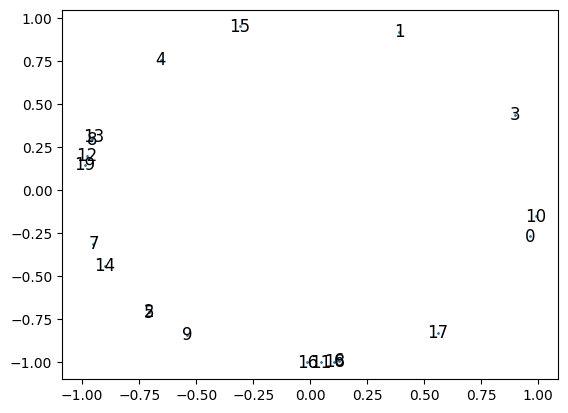

In [1]:
import numpy as np
import gudhi as gd
import tadasets
import matplotlib.pyplot as plt
sphere = tadasets.dsphere(n=20, d=1, noise=0, seed=42)
plt.scatter(sphere[:,0], sphere[:,1], s=1)
for i, (x, y) in enumerate(sphere):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')
rips = gd.RipsComplex(points=sphere, max_edge_length=1.8)
st = rips.create_simplex_tree(max_dimension=2)
filtration = list(st.get_filtration())

## Convert it to boundary map data

In [2]:
from src.filtrations import simplices_by_dimension, compute_boundary_matrices, filtration_hash_map

unique_filtration_values = sorted(list(set([f for (_, f) in filtration])))
simplices_by_dim, simplices_by_dim_only_filt = simplices_by_dimension(filtration)
boundary_matrices = compute_boundary_matrices(simplices_by_dim)
boundary_maps_index_dict = filtration_hash_map(filtration, simplices_by_dim_only_filt)


## Compute homology using persistent laplacians
For now, compute only first homology.
Lanczos library panics on diagonal matrices it seems.

In [3]:
import persistent_laplacians

result = persistent_laplacians.process_tda(
    boundary_matrices,
    boundary_maps_index_dict
)


thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace

thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value

thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value

thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value

thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value

thread '<un

## Persistent Betti numbers

In [7]:
from src.persistent_betty import persistent_betti_numbers
persistent_bettis = persistent_betti_numbers(result, unique_filtration_values)
persistent_bettis

{1: {(46, 141): 1}}

## Corresponding filtration values

In [5]:
(unique_filtration_values[46], unique_filtration_values[141])

(0.7011311593314402, 1.7622041348107578)

## Verify with Gudhi

In [6]:
import gudhi

sphere = tadasets.dsphere(n=20, d=1, noise=0, seed=42)
rips_complex = gudhi.RipsComplex(points=sphere, max_edge_length=3)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# Compute persistence
simplex_tree.persistence()

[(1, (0.7011311593314402, 1.7622041348107578)),
 (0, (0.0, inf)),
 (0, (0.0, 0.7009784890303917)),
 (0, (0.0, 0.6918225877025261)),
 (0, (0.0, 0.5960030633774311)),
 (0, (0.0, 0.5513991115782663)),
 (0, (0.0, 0.5353720218888437)),
 (0, (0.0, 0.4628597920109854)),
 (0, (0.0, 0.4581593493374387)),
 (0, (0.0, 0.3965677370192922)),
 (0, (0.0, 0.3317297308025137)),
 (0, (0.0, 0.21112086427509652)),
 (0, (0.0, 0.1368687277719028)),
 (0, (0.0, 0.11857189055045453)),
 (0, (0.0, 0.09980026648584228)),
 (0, (0.0, 0.06011218693087315)),
 (0, (0.0, 0.058810531396995824)),
 (0, (0.0, 0.05385351384112214)),
 (0, (0.0, 0.019616356985902084)),
 (0, (0.0, 0.014659691083728504)),
 (0, (0.0, 0.0025234211428959647))]